#### Import required libraries

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
torch.__version__

'2.6.0+cu124'

In [ ]:
torch.manual_seed(42)

#### Check GPU availability

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#### Define the Transforms to be applied on Dataset

In [ ]:
# Use the mean and sta from the CIFAR10
mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

trainTransform = torchvision.transforms.Compose(
    [
        # Apply transformations as mentioned in the paper
        torchvision.transforms.RandomCrop(32,padding = 4),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        # Resize the images from 32*32 to 224 * 224 (AlexNet requires images to be in 224*224 while CIFAR-10 has 32*32 images size)
        torchvision.transforms.Resize((224,224)),
        # Convert images to tensor
        torchvision.transforms.ToTensor(),
        # Apply Normalisation to the dataset
        torchvision.transforms.Normalize(mean=mean,std=std)
    ]
)

testTransform = torchvision.transforms.Compose(
    [
        # Resize the images from 32*32 to 224 * 224 (AlexNet requires images to be in 224*224 while CIFAR-10 has 32*32 images size)
        torchvision.transforms.Resize((224,224)),
        # Convert images to tensor
        torchvision.transforms.ToTensor(),
        # Apply Normalisation to the dataset
        torchvision.transforms.Normalize(mean=mean,std=std)
    ]
)

### Import the dataset

In [ ]:
from torchvision.datasets import CIFAR10

full_training_dataset = CIFAR10(root='./data',train=True, download=True,transform = trainTransform)
test_dataset =CIFAR10(root='./data',train=False, download=True,transform = testTransform)

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


#### Create DataLoader

In [ ]:
valSize = 5000
trainSize = len(full_training_dataset) - valSize

#split the training dataset into training and validation set to mimic the paper
training_dataset, valid_dataset = random_split(full_training_dataset,[trainSize,valSize])

trainLoader = DataLoader(training_dataset,shuffle=True,batch_size= 64,pin_memory=True)
testLoader = DataLoader(test_dataset,shuffle=False,batch_size = 64,pin_memory=True)
valLoader = DataLoader(valid_dataset,shuffle=False,batch_size=64,pin_memory=True)

In [ ]:
len(trainLoader) , len(testLoader),len(valLoader)
# get the lengths of the loaders

(704, 157, 79)

#### Define the architecture of AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self,outputFeatures):
        super().__init__()
        self.features = nn.Sequential(
            # Convolution Layer 1
            nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3,stride=2),
            # Convolution Layer 2
            nn.Conv2d(in_channels=96,out_channels=256,kernel_size = 5,stride = 1,padding = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3,stride=2),
            # Convolution Layer 3
            nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            # Convolution Layer 4
            nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            # Convolution Layer 5
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )

        self.classifier = nn.Sequential(
            # Fully Connected Layer 1
            nn.Dropout(p=0.5,inplace = True),
            nn.Linear(in_features=9216,out_features=4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            # Fully connected Layer 2
            nn.Dropout(p=0.5,inplace = True),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            # Fully connected Layer 3
            nn.Linear(in_features=4096,out_features = outputFeatures)
        )

    #Define the forward pass
    def forward(self,X):
        # Pass the image through the CNNs
        x = self.features(X)
        # Flatten the images for Full Connected Layers
        x = torch.flatten(x,1)
        # Pass the flattened image to fully connected Layer
        x = self.classifier(x)
        #return the output
        return x

#### Train the Model

In [ ]:
criterion = nn.CrossEntropyLoss()

model = AlexNet(outputFeatures=10)
model.to(device)

optimizer = optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9, weight_decay = 0.0005)
#performs very close to the paper to update the parameter
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
epochs = 20 # epochs = 40

# uncomment the below code if you want to resume training from a previous checkpoint
"""

resume = True
checkpoint_path = r''  # Change as needed

if resume:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    print(f"Resuming from epoch {start_epoch} with loss {loss:.2f}")
else:
    start_epoch = 0
"""

for epoch in range(epochs):

    model.train()
    totalEpochLoss = 0

    for batchFeatures,batchLabels in trainLoader:

        # move to gpu
        batchFeatures = batchFeatures.to(device)
        batchLabels = batchLabels.to(device)

        # forward Pass
        outputs = model(batchFeatures)

        # calculate loss
        loss = criterion(outputs,batchLabels)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()

        #update gradients
        optimizer.step()

        totalEpochLoss += loss.item()
    avgLoss = totalEpochLoss/len(trainLoader)

    print(f"Epoch:{epoch+1} | Loss:{avgLoss:.5f}")

    # Validation phase (to match the paper)
    model.eval()
    valLoss = 0.0
    with torch.no_grad():
        for valFeatures, valLabels in valLoader:
            valFeatures = valFeatures.to(device)
            valLabels = valLabels.to(device)
            valOutputs = model(valFeatures)
            valLoss += criterion(valOutputs, valLabels).item()

    avgValLoss = valLoss / len(valLoader)
    print(f"Epoch:{epoch+1} | Val Loss:{avgValLoss:.5f}")

    # Step the scheduler with validation loss
    scheduler.step(avgValLoss)

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f'' #add your own path
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': avgLoss
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")


Epoch:1 | Loss:1.62059
Epoch:1 | Val Loss:1.28121
Epoch:2 | Loss:1.28291
Epoch:2 | Val Loss:1.16829
Epoch:3 | Loss:1.09488
Epoch:3 | Val Loss:1.22416
Epoch:4 | Loss:0.99035
Epoch:4 | Val Loss:0.87134
Epoch:5 | Loss:0.88414
Epoch:5 | Val Loss:0.82054
Epoch:6 | Loss:0.81090
Epoch:6 | Val Loss:0.73680
Epoch:7 | Loss:0.75486
Epoch:7 | Val Loss:0.75736
Epoch:8 | Loss:0.70105
Epoch:8 | Val Loss:0.64831
Epoch:9 | Loss:0.66518
Epoch:9 | Val Loss:0.65577
Epoch:10 | Loss:0.61967
Epoch:10 | Val Loss:0.65380
Checkpoint saved: 
Epoch:11 | Loss:0.59895
Epoch:11 | Val Loss:0.61645
Epoch:12 | Loss:0.56739
Epoch:12 | Val Loss:0.61664
Epoch:13 | Loss:0.53142
Epoch:13 | Val Loss:0.60587
Epoch:14 | Loss:0.50821
Epoch:14 | Val Loss:0.55391
Epoch:15 | Loss:0.48561
Epoch:15 | Val Loss:0.54349
Epoch:16 | Loss:0.45536
Epoch:16 | Val Loss:0.48572
Epoch:17 | Loss:0.43640
Epoch:17 | Val Loss:0.50515
Epoch:18 | Loss:0.43850
Epoch:18 | Val Loss:0.54832
Epoch:19 | Loss:0.41468
Epoch:19 | Val Loss:0.47366
Epoch:20 | 

### Evalution Loop on Test data

In [ ]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d

#### Evaluation on Testing Set

In [ ]:
total = 0
correct = 0

with torch.no_grad():
    for batchFeatures,batchLabels in testLoader:

        # move to gpu
        batchFeatures = batchFeatures.to(device)
        batchLabels = batchLabels.to(device)

        # forward Pass
        outputs = model(batchFeatures)

        # calculate loss
        _,predicted = torch.max(outputs.data,1)

        total += batchLabels.shape[0]

        correct += (predicted == batchLabels).sum().item()

    print(f"Accuracy on test set:{correct/total}")

Accuracy on test set:0.8596


### Evalution on Training Set

In [ ]:
total = 0
correct = 0

with torch.no_grad():
    for batchFeatures,batchLabels in trainLoader:

        # move to gpu
        batchFeatures = batchFeatures.to(device)
        batchLabels = batchLabels.to(device)

        # forward Pass
        outputs = model(batchFeatures)

        # calculate loss
        _,predicted = torch.max(outputs.data,1)

        total += batchLabels.shape[0]

        correct += (predicted == batchLabels).sum().item()

    print(f"Accuracy on train set:{correct/total}")

Accuracy on train set:0.9014


#### Predictions

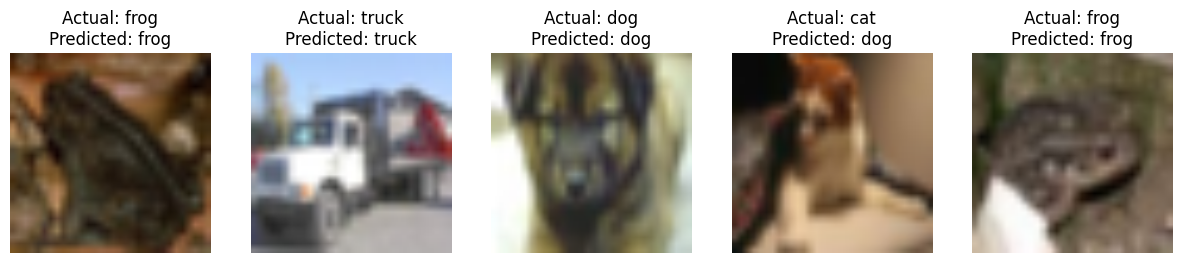

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from random import sample

# Define CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Set model to evaluation mode
model.eval()

# Disable gradients for prediction
with torch.no_grad():
    # Get a batch from test_loader
    for batch_features, batch_labels in testLoader:
        # Move to GPU
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # Predict
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, dim=1)  # Get predicted class indices

        # Select N random images (N=5)
        N = 5
        indices = sample(range(batch_features.size(0)), N)  # Random indices in batch

        # Plot images with actual and predicted labels
        plt.figure(figsize=(15, 5))
        for i in range(N):
            # Get image, actual label, predicted label
            img = batch_features[indices[i]].cpu()  # Tensor: [3, 224, 224]
            actual = classes[batch_labels[indices[i]].item()]
            pred = classes[predicted[indices[i]].item()]

            # Denormalize image for display
            img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)  # Undo normalization
            img = img.permute(1, 2, 0)  # Reshape: [224, 224, 3]
            img = torch.clamp(img, 0, 1)  # Ensure pixel values in [0, 1]

            # Create subplot
            plt.subplot(1, N, i+1)
            plt.imshow(img.numpy())
            plt.title(f'Actual: {actual}\nPredicted: {pred}')
            plt.axis('off')

        plt.show()
        break  # Only process one batch